In [367]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import numpy as np
import matplotlib.pyplot as plt

In [368]:
def df_treat(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }
    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    exp_num_list = sorted(ndf['exp'].unique())

    return df, ndf, range_mm, exp_num_list

In [369]:
def seq_data(ndf, exp_num_list):
    seq = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in exp_num_list:
        exp_df = ndf[ndf['exp'] == exp]
        seq.append(exp_df[feature_cols].values)
    
    return seq

In [370]:
def pad_seq(seq):
    max_len = max([len(s) for s in seq])
    seq_len = [len(s) for s in seq]
    pad_seq = pad_sequence([torch.tensor(s) for s in seq], batch_first=True, padding_value=0)

    return pad_seq, seq_len, max_len

In [371]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [372]:
class LayerNormLSTM(nn.Module):
    """LSTM layer with layer normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4 * hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_h = nn.LayerNorm(hidden_node)
        self.ln_g = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)

        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_g, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_g, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_h(i_f + h_f))
        g_g = torch.tanh(self.ln_g(i_g + h_g))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * g_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

In [373]:
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()

        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)

        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, input_node = x.size()
        device = x.device

        h_states = []
        c_states = []
        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))

                # Inplace 연산 대신 새로운 텐서 생성
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)
        
        output_tensor = torch.stack(outputs, dim=1)
        
        normalized = self.final_layer_norm(output_tensor)
        return self.final_dropout(normalized)

In [374]:
class PhysicalChangeDecoder(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(hidden_node, output_node))
    
    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [375]:
class CurrentPredictor(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        self.layers.append(nn.Linear(hidden_node, 1))
    
    def forward(self, new_state):
        x = new_state
        for layer in self.layers:
            x = layer(x)
        return x

In [376]:
class PhysicsConstraintLayer(nn.Module):
    def __init__(self, range_mm, current_predictor, eps=1e-2):
        super().__init__()
        self.sps = eps
        self.current_predictor = current_predictor
        self.register_buffer('range_mm_tensor', self._convert_range_to_tensor(range_mm))

    def _convert_range_to_tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def normalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def denormalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return data * (max_val - min_val) + min_val

    def forward(self, physical_changes, current_state):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self.denormalize(current_state[..., 2:3], VF_idx)
        VA = self.denormalize(current_state[..., 3:4], VA_idx)
        VB = self.denormalize(current_state[..., 4:5], VB_idx)
        CFLA = self.denormalize(current_state[..., 5:6], CFLA_idx)
        CALA = self.denormalize(current_state[..., 6:7], CALA_idx)
        CFK = self.denormalize(current_state[..., 7:8], CFK_idx)
        CBK = self.denormalize(current_state[..., 8:9], CBK_idx)

        dVA = physical_changes[..., 0:1]
        dVB = physical_changes[..., 1:2]
        dNALA = physical_changes[..., 2:3]
        dNBK = physical_changes[..., 3:4]

        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        nVF = torch.clamp(nVF, min=self.sps)
        nVA = torch.clamp(nVA, min=self.sps)
        nVB = torch.clamp(nVB, min=self.sps)
        
        nNFLA = NFLA - torch.clamp(dNALA, min=0.0)
        nNALA = NALA + torch.clamp(dNALA, min=0.0)
        nNFK = NFK - torch.clamp(dNBK, min=0.0)
        nNBK = NBK + torch.clamp(dNBK, min=0.0)

        nNFLA = torch.clamp(nNFLA, min=0.0)
        nNALA = torch.clamp(nNALA, min=0.0)
        nNFK = torch.clamp(nNFK, min=0.0)
        nNBK = torch.clamp(nNBK, min=0.0)

        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        V = current_state[..., 0:1]
        E = current_state[..., 1:2]
        nVF_norm = self.normalize(nVF, VF_idx)
        nVA_norm = self.normalize(nVA, VA_idx)
        nVB_norm = self.normalize(nVB, VB_idx)
        nCFLA_norm = self.normalize(nCFLA, CFLA_idx)
        nCALA_norm = self.normalize(nCALA, CALA_idx)
        nCFK_norm = self.normalize(nCFK, CFK_idx)
        nCBK_norm = self.normalize(nCBK, CBK_idx)

        # Create temporary state without I for current prediction
        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        # Predict new I using the current predictor
        nI_pred_norm = self.current_predictor(temp_state)
        
        # Scale predicted I to actual range
        nI_real = self.denormalize(nI_pred_norm, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self.normalize(nI_real, I_idx)

        # Create final next state with predicted I
        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        return next_state

In [377]:
class BMEDAutoregressiveModel(nn.Module):
    def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.current_predictor = CurrentPredictor(**current_predictor_params)
        self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)

    def forward(self, x, seq_len):
        hidden_states = self.state_extr(x, seq_len)
        physical_changes = self.physical_decoder(hidden_states)
        new_x = self.physics_constraint(physical_changes, x)
        
        return new_x

In [378]:
def masked_mse_loss(pred, target, seq_len):
    batch_size, max_len, features = pred.shape
    seq_len_cpu = seq_len.detach().cpu().long()

    mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
    mask = mask.float().to(pred.device)

    loss = F.mse_loss(pred, target, reduction='none')
    masked_loss = loss * mask.unsqueeze(-1)

    total_loss = masked_loss.sum()
    total_elements = mask.sum()

    masked_loss = total_loss / total_elements
    return masked_loss

In [379]:
def tf_data(input_seq, seq_len):
    inputs = input_seq[:, :-1, :-1]
    targets = input_seq[:, 1:, :]

    target_seq_len = seq_len - 1

    return inputs, targets, target_seq_len

In [380]:
class NoamScheduler:
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0

    def step_epoch(self):
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
    
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [381]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df, ndf, range_mm, exp_num_list = df_treat('BMED_DATA_AG.csv')
seq = seq_data(ndf, exp_num_list)
pad, seq_len, max_len = pad_seq(seq)
dataset = gen_dataset(pad, seq_len)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [382]:
state_extr_params = {
    'input_node': 9,
    'hidden_node': 48,
    'n_layer': 4,
    'dropout': 0.3
}

decoder_params = {
    'input_node': state_extr_params['hidden_node'],
    'hidden_node': 48,
    'n_layer': 3,
    'dropout': 0.4,
    'output_node': 4
}

current_predictor_params = {
    'input_node': 9,
    'hidden_node': 96,
    'n_layer': 4,
    'dropout': 0.4
}

model = BMEDAutoregressiveModel(state_extr_params, decoder_params, current_predictor_params, range_mm)
model = model.to(device)
print(f"Model architecture:")
print(f"  Input features: {state_extr_params['input_node']} (without current)")
print(f"  State Extractor Hidden size: {state_extr_params['hidden_node']}")
print(f"  State Extractor layers: {state_extr_params['n_layer']}")
print(f"  Decoder layers: {decoder_params['n_layer']}")
print(f"  Decoder Hidden size: {decoder_params['hidden_node']}")
print(f"  Current Predictor layers: {current_predictor_params['n_layer']}")
print(f"  Current Predictor Hidden size: {current_predictor_params['hidden_node']}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Physics constraints: Volume conservation with denormalization")

num_epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0)
warmup_epochs = int(num_epochs * 0.1)
scheduler = NoamScheduler(optimizer, model_size=state_extr_params['hidden_node'], warmup_epochs=warmup_epochs, factor=1)

print(f"\nTraining configuration:")
print(f"  Total epochs: {num_epochs:,}")
print(f"  Warmup epochs: {warmup_epochs:,} (10%)")
peak_lr = 1.0 * (48 ** (-0.5)) * (warmup_epochs ** (-0.5))
print(f"  Peak learning rate: {peak_lr:.2e}")

Model architecture:
  Input features: 9 (without current)
  State Extractor Hidden size: 48
  State Extractor layers: 4
  Decoder layers: 3
  Decoder Hidden size: 48
  Current Predictor layers: 4
  Current Predictor Hidden size: 96
  Model parameters: 105,557
  Physics constraints: Volume conservation with denormalization

Training configuration:
  Total epochs: 200
  Warmup epochs: 20 (10%)
  Peak learning rate: 3.23e-02


In [383]:
train_samples = len(dataloader.dataset)
best_train_loss = float('inf')
best_epoch = 0
train_losses = []
learning_rates = []

best_model = None

print("Training started...")
print(f"Total batches per epoch: {len(dataloader)}")

for epoch in range(num_epochs):
    current_lr = scheduler.step_epoch()

    model.train()
    train_loss = 0.0
    train_batches = 0

    for batch_idx, (input_seq, seq_len) in enumerate(dataloader):
        try:
            input_seq = input_seq.to(device)
            seq_len = seq_len.to(device)

            inputs, targets, target_seq_len = tf_data(input_seq, seq_len)
            
            optimizer.zero_grad()
            pred = model(inputs, target_seq_len)
            loss = masked_mse_loss(pred, targets, target_seq_len)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        except Exception as e:
            print(f"Training batch {batch_idx} error: {str(e)}")
            print(f"Input shape: {input_seq.shape if 'input_seq' in locals() else 'N/A'}")
            print(f"Seq lengths: {seq_len if 'seq_lengths' in locals() else 'N/A'}")
            import traceback
            traceback.print_exc()
            continue
    
    if train_batches == 0:
        print("No valid training batches")
        break

    train_losses.append(train_loss)
    learning_rates.append(current_lr)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_epoch = epoch + 1
        best_status = " ★ NEW BEST"
        
        # Best model을 메모리에 복사하여 저장
        import copy
        best_model = copy.deepcopy(model)
        print(f"          Best model saved in memory at epoch {best_epoch}")
    else:
        best_status = ""

    # Warmup 구간 표시
    if epoch + 1 <= warmup_epochs:
        warmup_status = " [WARMUP]"
    else:
        warmup_status = ""

    # 매 에포크마다 로깅 - best 성능 정보 포함
    print(f"Epoch {epoch+1:4d}: Train: {train_loss:.6f}, LR: {current_lr:.2e}{best_status}{warmup_status}")    

    if epoch == 0:
        print(f"          Best: Train: {best_train_loss:.6f}, (Epoch {best_epoch})")
    elif train_loss < best_train_loss:
        print(f"          ✓ Updated Best: Train: {best_train_loss:.6f}")
    else:
        print(f"          Best: Train: {best_train_loss:.6f} (Epoch {best_epoch})")

print(f"\nTraining completed!")
print(f"=" * 60)

# 안전한 결과 출력
if len(train_losses) > 0:
    print(f"Best Performance (Epoch {best_epoch}):")
    print(f"  Best Train Loss:  {best_train_loss:.6f}")
    print(f"=" * 60)
    print(f"Final Performance (Epoch {len(train_losses)}):")
    print(f"  Final Train Loss: {train_losses[-1]:.6f}")
    print(f"  Final LR:         {current_lr:.2e}")
    print(f"=" * 60)
    if len(learning_rates) > 0:
        print(f"Warmup completed at epoch {warmup_epochs} with peak LR: {max(learning_rates):.2e}")
else:
    print("⚠️ No training completed - check error messages above")

# Best model이 저장되었는지 확인
if best_model is not None:
    print(f"\n✅ Best model (Epoch {best_epoch}) successfully saved in memory!")
    print(f"   Best model loss: {best_train_loss:.6f}")
else:
    print("\n⚠️ No best model was saved (training may have failed)")
    best_model = model  # fallback to current model


Training started...
Total batches per epoch: 6


          Best model saved in memory at epoch 1
Epoch    1: Train: 166.071445, LR: 1.61e-03 ★ NEW BEST [WARMUP]
          Best: Train: 166.071445, (Epoch 1)
          Best model saved in memory at epoch 2
Epoch    2: Train: 30.868636, LR: 3.23e-03 ★ NEW BEST [WARMUP]
          Best: Train: 30.868636 (Epoch 2)
Epoch    3: Train: 52.006833, LR: 4.84e-03 [WARMUP]
          Best: Train: 30.868636 (Epoch 2)
          Best model saved in memory at epoch 4
Epoch    4: Train: 1.426456, LR: 6.45e-03 ★ NEW BEST [WARMUP]
          Best: Train: 1.426456 (Epoch 4)
          Best model saved in memory at epoch 5
Epoch    5: Train: 0.902560, LR: 8.07e-03 ★ NEW BEST [WARMUP]
          Best: Train: 0.902560 (Epoch 5)
          Best model saved in memory at epoch 6
Epoch    6: Train: 0.816294, LR: 9.68e-03 ★ NEW BEST [WARMUP]
          Best: Train: 0.816294 (Epoch 6)
          Best model saved in memory at epoch 7
Epoch    7: Train: 0.804213, LR: 1.13e-02 ★ NEW BEST [WARMUP]
          Best: Train: 0.804

KeyboardInterrupt: 

✅ Best Model (Epoch 180, Loss: 0.269622) 사용하여 평가를 진행합니다.
🔍 전체 실험 데이터 분석 중...
📋 실험 번호 매핑:
   - CSV 실험 번호 → 데이터로더 인덱스: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(8): 8, np.int64(9): 9, np.int64(10): 10, np.int64(11): 11, np.int64(12): 12, np.int64(13): 13, np.int64(14): 14, np.int64(15): 15, np.int64(16): 16, np.int64(17): 17, np.int64(18): 18, np.int64(19): 19, np.int64(20): 20, np.int64(21): 21, np.int64(22): 22, np.int64(23): 23}
   - 데이터로더 인덱스 → CSV 실험 번호: {0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4), 5: np.int64(5), 6: np.int64(6), 7: np.int64(7), 8: np.int64(8), 9: np.int64(9), 10: np.int64(10), 11: np.int64(11), 12: np.int64(12), 13: np.int64(13), 14: np.int64(14), 15: np.int64(15), 16: np.int64(16), 17: np.int64(17), 18: np.int64(18), 19: np.int64(19), 20: np.int64(20), 21: np.int64(21), 22: np.int64(22), 23: np.int64(23)}

📋 사용 가능한 전체 실험 목록:
실험번호     

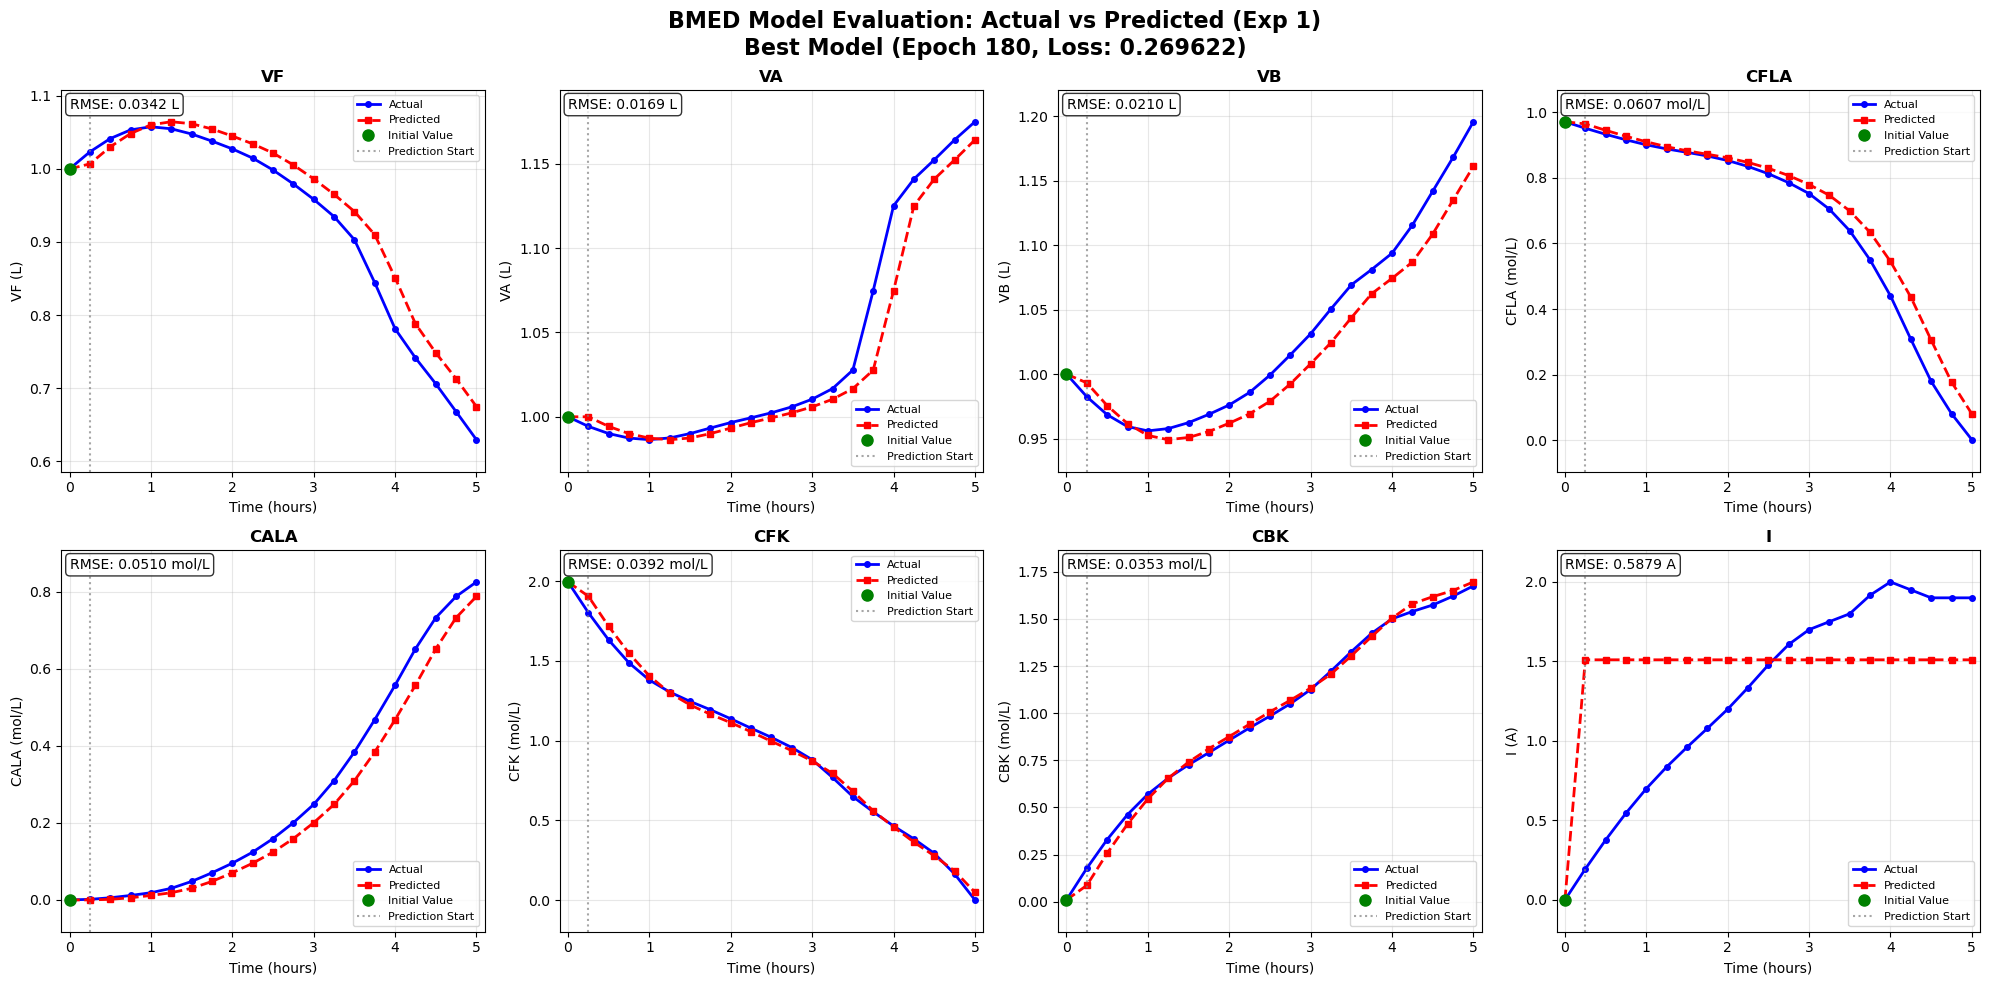

MODEL EVALUATION RESULTS - Experiment 1
Best Model (Epoch 180, Loss: 0.269622)
Initial time point: t = 0.00 hours
Prediction starts from: t = 0.25 hours
Total sequence length: 21 points
Prediction sequence length: 20 points
--------------------------------------------------------------------------------
VF    : Initial=1.0000 L, RMSE=0.0342 L, MAE=0.0287 L, MAPE=3.47%, R²=0.9405
VA    : Initial=1.0000 L, RMSE=0.0169 L, MAE=0.0101 L, MAPE=0.93%, R²=0.9369
VB    : Initial=1.0000 L, RMSE=0.0210 L, MAE=0.0187 L, MAPE=1.76%, R²=0.9207
CFLA  : Initial=0.9712 mol/L, RMSE=0.0607 mol/L, MAE=0.0435 mol/L, MAPE=301.56%, R²=0.9573
CALA  : Initial=0.0000 mol/L, RMSE=0.0510 mol/L, MAE=0.0413 mol/L, MAPE=29.53%, R²=0.9666
CFK   : Initial=1.9944 mol/L, RMSE=0.0392 mol/L, MAE=0.0301 mol/L, MAPE=329.47%, R²=0.9936
CBK   : Initial=0.0097 mol/L, RMSE=0.0353 mol/L, MAE=0.0278 mol/L, MAPE=5.75%, R²=0.9936
I     : Initial=0.0000 A, RMSE=0.5879 A, MAE=0.4858 A, MAPE=83.24%, R²=-0.0733
------------------------

In [ ]:
# 모델 평가: 실제 vs 예측 데이터 비교 (denormalized 원본 단위, Best Model 사용)
import matplotlib.pyplot as plt
import numpy as np

# normalization에 사용된 range_mm 복원 (전체 데이터 기준)
original_df = pd.read_csv('BMED_DATA_AG.csv')

range_mm = {
    'V': {'min': original_df['V'].min()*0.8, 'max': original_df['V'].max()*1.2},
    'E': {'min': original_df['E'].min()*0.8, 'max': original_df['E'].max()*1.2},
    'VF': {'min': original_df['VF'].min()*0.8, 'max': original_df['VF'].max()*1.2},
    'VA': {'min': original_df['VA'].min()*0.8, 'max': original_df['VA'].max()*1.2},
    'VB': {'min': original_df['VB'].min()*0.8, 'max': original_df['VB'].max()*1.2},
    'CFLA': {'min': 0, 'max': original_df['CFLA'].max()*1.2},
    'CALA': {'min': 0, 'max': original_df['CALA'].max()*1.2},
    'CFK': {'min': 0, 'max': original_df['CFK'].max()*1.2},
    'CBK': {'min': 0, 'max': original_df['CBK'].max()*1.2},
    'I': {'min': 0, 'max': original_df['I'].max()*1.2},
}

def denormalize_data(normalized_data, feature_name):
    """정규화된 데이터를 원래 단위로 복원"""
    if feature_name in range_mm:
        min_val = range_mm[feature_name]['min']
        max_val = range_mm[feature_name]['max']
        return normalized_data * (max_val - min_val) + min_val
    return normalized_data

# feature 정보 정의
feature_names = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
feature_indices = [2, 3, 4, 5, 6, 7, 8, 9]
feature_units = ['L', 'L', 'L', 'mol/L', 'mol/L', 'mol/L', 'mol/L', 'A']

# Best model 확인
if best_model is None:
    print("❌ Best model이 저장되지 않았습니다. 현재 모델을 사용합니다.")
    evaluation_model = model
    model_info = "Current Model"
else:
    evaluation_model = best_model
    model_info = f"Best Model (Epoch {best_epoch}, Loss: {best_train_loss:.6f})"
    print(f"✅ {model_info} 사용하여 평가를 진행합니다.")

# 전체 실험 데이터 정보 확인
print("🔍 전체 실험 데이터 분석 중...")

# 실험 번호와 데이터로더 인덱스 매핑 생성
exp_num_to_dataloader_idx = {}
dataloader_idx_to_exp_num = {}

for i, exp_num in enumerate(sorted(ndf['exp'].unique())):
    exp_num_to_dataloader_idx[exp_num] = i
    dataloader_idx_to_exp_num[i] = exp_num

print(f"📋 실험 번호 매핑:")
print(f"   - CSV 실험 번호 → 데이터로더 인덱스: {exp_num_to_dataloader_idx}")
print(f"   - 데이터로더 인덱스 → CSV 실험 번호: {dataloader_idx_to_exp_num}")

# 모든 실험 정보 수집
all_experiments_info = []
for i, (input_seq, seq_lengths) in enumerate(dataloader):
    seq_len = seq_lengths[0].item()
    duration = seq_len * 0.25
    
    # 첫 번째 시점의 조건 추출
    initial_conditions = input_seq[0, 0]  # 첫 번째 배치, 첫 번째 시점
    voltage = denormalize_data(initial_conditions[0].item(), 'V')
    electrolyte = denormalize_data(initial_conditions[1].item(), 'E')
    
    # 실제 실험 번호 가져오기
    actual_exp_num = dataloader_idx_to_exp_num[i]
    
    all_experiments_info.append({
        'dataloader_idx': i,
        'actual_exp_num': actual_exp_num,
        'seq_length': seq_len,
        'duration_hours': duration,
        'voltage': voltage,
        'electrolyte': electrolyte
    })

# 사용 가능한 실험 목록 출력
print("\n📋 사용 가능한 전체 실험 목록:")
print("="*90)
print(f"{'실험번호':<8} {'데이터로더인덱스':<12} {'시간길이':<10} {'전압(V)':<10} {'전해질농도(M)':<15} {'설명'}")
print("-"*90)

for exp_info in all_experiments_info:
    print(f"{exp_info['actual_exp_num']:<8} {exp_info['dataloader_idx']:<12} {exp_info['duration_hours']:<10.2f} {exp_info['voltage']:<10.1f} {exp_info['electrolyte']:<15.3f} "
          f"실험조건 {exp_info['actual_exp_num']}")

print("="*90)

# 실험 선택 옵션 - 실제 실험 번호 사용
available_exp_nums = [exp['actual_exp_num'] for exp in all_experiments_info]
print(f"\n🎯 실험 선택 옵션:")
print(f"   - 사용 가능한 실험 번호: {available_exp_nums}")
print(f"   - 총 {len(available_exp_nums)}개 실험 데이터 available")

# 기본값 설정 - 실제 실험 번호 사용
exp_to_evaluate = 1  # 원하는 실험 번호로 변경 가능 
print(f"\n📊 현재 선택된 실험: {exp_to_evaluate}")

# 선택된 실험이 유효한지 확인
if exp_to_evaluate not in available_exp_nums:
    print(f"⚠️  실험 {exp_to_evaluate}을 찾을 수 없습니다. 첫 번째 실험({available_exp_nums[0]})을 사용합니다.")
    exp_to_evaluate = available_exp_nums[0]
else:
    print(f"✅ 실험 {exp_to_evaluate}이 발견되었습니다!")

# 실제 실험 번호를 데이터로더 인덱스로 변환
dataloader_idx_to_use = exp_num_to_dataloader_idx[exp_to_evaluate]

# 선택된 실험 정보 출력
selected_exp_info = all_experiments_info[dataloader_idx_to_use]
print(f"\n🔬 선택된 실험 {exp_to_evaluate} 상세 정보:")
print(f"   - 데이터로더 인덱스: {dataloader_idx_to_use}")
print(f"   - 시퀀스 길이: {selected_exp_info['seq_length']} 시점")
print(f"   - 실험 시간: {selected_exp_info['duration_hours']:.2f} 시간")
print(f"   - 전압: {selected_exp_info['voltage']:.1f} V")
print(f"   - 외부 전해질 농도: {selected_exp_info['electrolyte']:.3f} M")

evaluation_model.eval()
with torch.no_grad():
    # 선택된 실험의 데이터 가져오기 (데이터로더 인덱스 사용)
    for i, (input_seq, seq_lengths) in enumerate(dataloader):
        if i == dataloader_idx_to_use:
            selected_input_seq = input_seq.to(device)
            selected_seq_lengths = seq_lengths.to(device)
            break
    else:
        print(f"⚠️ 데이터로더에서 인덱스 {dataloader_idx_to_use}를 찾을 수 없습니다. 첫 번째 실험을 사용합니다.")
        selected_input_seq, selected_seq_lengths = next(iter(dataloader))
        selected_input_seq = selected_input_seq.to(device)
        selected_seq_lengths = selected_seq_lengths.to(device)
        exp_to_evaluate = available_exp_nums[0]
        dataloader_idx_to_use = 0
        selected_exp_info = all_experiments_info[0]  # 첫 번째 실험 정보로 업데이트
    
    # Teacher forcing 데이터 준비
    inputs, targets, target_seq_lengths = tf_data(selected_input_seq, selected_seq_lengths)
    
    # Best model로 예측
    predictions = evaluation_model(inputs, target_seq_lengths)
    
    # CPU로 이동하여 시각화 준비
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()
    input_seq_cpu = selected_input_seq.cpu().numpy()
    
    # 첫 번째 샘플 (batch의 첫 번째) 사용
    pred_sample = predictions[0]
    actual_sample = targets[0]
    initial_sample = input_seq_cpu[0]  # 초기값 포함된 전체 시퀀스
    seq_len = target_seq_lengths[0].item()
    full_seq_len = selected_seq_lengths[0].item()
    
    # 실제 시퀀스 길이만큼만 사용
    pred_sample = pred_sample[:seq_len]
    actual_sample = actual_sample[:seq_len]
    initial_sample = initial_sample[:full_seq_len]

# 실험 조건 정보 출력
print(f"🔬 실험 조건:")
print(f"   - 실험 번호: {exp_to_evaluate}")
print(f"   - 전압(V): {denormalize_data(initial_sample[0, 0], 'V'):.1f} V")
print(f"   - 외부 전해질 농도(E): {denormalize_data(initial_sample[0, 1], 'E'):.2f} M")
print(f"   - 시퀀스 길이: {full_seq_len} 시점 ({full_seq_len*0.25:.2f} 시간)")

# 시간 축 생성
time_points = np.arange(full_seq_len) * 0.25  # 전체 시간축 (0.0부터)

# 예측값을 초기값과 연결하여 전체 시퀀스 구성
prediction_full = np.zeros((full_seq_len, 10))
# 첫 번째 시점은 초기값 사용
prediction_full[0] = initial_sample[0]
# 나머지 시점은 모델 예측값 사용
prediction_full[1:seq_len+1] = pred_sample

# 2x4 subplot 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'BMED Model Evaluation: Actual vs Predicted (Exp {exp_to_evaluate})\n{model_info}', fontsize=16, fontweight='bold')

for i, (feature_name, feature_idx, unit) in enumerate(zip(feature_names, feature_indices, feature_units)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    # 데이터를 원래 단위로 denormalize
    actual_denorm = denormalize_data(initial_sample[:, feature_idx], feature_name)
    pred_denorm = denormalize_data(prediction_full[:seq_len+1, feature_idx], feature_name)
    
    # 실제 데이터 (전체 시퀀스)
    ax.plot(time_points, actual_denorm, 'b-', linewidth=2, label='Actual', marker='o', markersize=4)
    
    # 예측 데이터 (초기값부터 연결된 전체 시퀀스)
    ax.plot(time_points[:seq_len+1], pred_denorm, 'r--', linewidth=2, label='Predicted', marker='s', markersize=4)
    
    # 초기값 강조 표시
    ax.plot(time_points[0], actual_denorm[0], 'go', markersize=8, label='Initial Value')
    
    # 예측 시작점 표시
    ax.axvline(x=time_points[1], color='gray', linestyle=':', alpha=0.7, label='Prediction Start')
    
    # 그래프 설정
    ax.set_title(f'{feature_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=10)
    ax.set_ylabel(f'{feature_name} ({unit})', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # RMSE 계산 및 표시 (denormalized 값으로, 예측 구간만)
    actual_pred_denorm = denormalize_data(actual_sample[:, feature_idx], feature_name)
    pred_pred_denorm = denormalize_data(pred_sample[:, feature_idx], feature_name)
    rmse = np.sqrt(np.mean((actual_pred_denorm - pred_pred_denorm)**2))
    ax.text(0.02, 0.98, f'RMSE: {rmse:.4f} {unit}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # y축 범위 설정 (전체 데이터 고려)
    all_values = np.concatenate([actual_denorm, pred_denorm])
    y_min = all_values.min()
    y_max = all_values.max()
    y_range = y_max - y_min
    if y_range > 0:
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    # x축 범위 설정
    ax.set_xlim(-0.1, time_points[seq_len] + 0.1)

plt.tight_layout()
plt.show()

# 전체 성능 지표 계산 (denormalized)
print("="*80)
print(f"MODEL EVALUATION RESULTS - Experiment {exp_to_evaluate}")
print(f"{model_info}")
print("="*80)
print(f"Initial time point: t = {time_points[0]:.2f} hours")
print(f"Prediction starts from: t = {time_points[1]:.2f} hours")
print(f"Total sequence length: {full_seq_len} points")
print(f"Prediction sequence length: {seq_len} points")
print("-"*80)

total_rmse = 0
for i, (feature_name, unit) in enumerate(zip(feature_names, feature_units)):
    feature_idx = feature_indices[i]
    
    # denormalized 값으로 성능 지표 계산
    actual_vals_denorm = denormalize_data(actual_sample[:, feature_idx], feature_name)
    pred_vals_denorm = denormalize_data(pred_sample[:, feature_idx], feature_name)
    initial_val_denorm = denormalize_data(initial_sample[0, feature_idx], feature_name)
    
    # 성능 지표 계산
    rmse = np.sqrt(np.mean((actual_vals_denorm - pred_vals_denorm)**2))
    mae = np.mean(np.abs(actual_vals_denorm - pred_vals_denorm))
    mape = np.mean(np.abs((actual_vals_denorm - pred_vals_denorm) / (actual_vals_denorm + 1e-8))) * 100  # MAPE (%)
    r2 = 1 - (np.sum((actual_vals_denorm - pred_vals_denorm)**2) / np.sum((actual_vals_denorm - np.mean(actual_vals_denorm))**2))
    
    print(f"{feature_name:6s}: Initial={initial_val_denorm:.4f} {unit}, RMSE={rmse:.4f} {unit}, MAE={mae:.4f} {unit}, MAPE={mape:.2f}%, R²={r2:.4f}")
    total_rmse += rmse

avg_rmse = total_rmse / len(feature_names)
print("-"*80)
print(f"AVERAGE: RMSE={avg_rmse:.4f} (mixed units)")
if best_model is not None:
    print(f"✅ Best training loss: {best_train_loss:.6f} (Epoch {best_epoch})")
print("="*80)

# 실험 변경 방법 안내
print(f"\n💡 다른 실험을 평가하려면:")
print(f"   - 코드의 'exp_to_evaluate = {exp_to_evaluate}' 부분을 원하는 실험 번호로 수정하세요")
print(f"   - 사용 가능한 실험 번호: {available_exp_nums}")
print(f"   - 현재 설정: Experiment {exp_to_evaluate} (데이터로더 인덱스: {dataloader_idx_to_use})")
print(f"   - 총 {len(available_exp_nums)}개 실험 중에서 선택 가능합니다")

# 실험 번호 매핑 정보 출력
print(f"\n🔄 실험 번호 매핑 정보:")
for exp_info in all_experiments_info:
    print(f"   - 실험 {exp_info['actual_exp_num']} → 데이터로더 인덱스 {exp_info['dataloader_idx']}")

# 추가 분석을 위한 함수 정의
def evaluate_specific_experiment(exp_num):
    """특정 실험을 평가하는 함수"""
    if exp_num not in available_exp_nums:
        print(f"❌ 실험 {exp_num}는 사용할 수 없습니다. 사용 가능한 실험: {available_exp_nums}")
        return
    
    dataloader_idx = exp_num_to_dataloader_idx[exp_num]
    print(f"\n🔄 실험 {exp_num} (데이터로더 인덱스: {dataloader_idx}) 평가를 시작합니다...")
    # 여기에 평가 코드를 추가할 수 있습니다
    
print(f"\n📌 함수 사용법:")
print(f"   evaluate_specific_experiment(실험번호)  # 예: evaluate_specific_experiment(3)")
print(f"   실제 실험 번호를 입력하여 개별 평가를 수행할 수 있습니다.")